# База знань про методи виготовлення різьби
Цей інтерактивний документ Jupyter призначений для роботи з базою знань про методи виготовлення різьби. Користувач може переглядати факти бази знань у вигляді таблиці або графа, створювати запити до бази знань, додавати (або видаляти) факти вручну або шляхом застосування механізму логічного виведення.

База знань складається з множини фактів і множини правил логічного виведення. Факти бази знань подані як триплети (суб'єкт, предикат, об'єкт) або (s, p, o). Триплети зберігаються у файлі формату CSV. Для зручного оброблення за допомогою пакету pandas ці триплети завантажуються в таблицю df (DataFrame). Ця таблиця df створюється в модулі mykb.

Віджети IPyWidgets (текстові поля і кнопки) дозволяють інтерактивну роботу з БЗ - пошук триплетів за шаблоном, додавання нових триплетів та їх видалення.

Для візуалізації графа бази знань використовуються пакети NetworkX (створює граф) та Matplotlib (візуалізує граф). NetworkX також можна використати для застосування різноманітних алгоритмів на графах.

Правила і машина виведення описані в модулі example3. Правила логічного виведення (rule1, rule2) дозволяють виводити нові факти за допомогою машини логічного виведення (reasoner). Машина виведення виконує "пряме виведення" та використовує підхід "а-ля RETE" для пришвидшення алгоритму, тобто будує дерево триплетів для швидкого пошуку.

Послідовність запуску через JupyterLite:

1. Відкрийте в браузері https://jupyter.org/try-jupyter/lab/
2. Перетягніть у File Browser (зліва) файли TextSelectInteractKB.ipynb, kb.csv, mykb.py, example3.py
3. Запустіть TextSelectInteractKB.ipynb і виконайте усі комірки

In [22]:
# установлюємо пакети
%pip install -q ipywidgets==8.1.3
%pip install -q pandas

In [23]:
# імпорт пакету для створення віджетів
import ipywidgets, pandas
# імпорт функції для візуалізації результатів
from IPython.display import display, Javascript

In [24]:
# з модуля mykb імпортуємо таблицю з фактами бази знань (s, p, o)
import sys
sys.path.append(".")
from mykb import df

In [25]:
# приклад запиту до бази знань:
# вивести таблицю усіх фактів (s, p, o), де s містить "різ" і p містить "перевага"
df[df["s"].str.contains("бол")][df["p"].str.contains("перевага")]

<ipython-input-25-cb388075b5de>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["s"].str.contains("бол")][df["p"].str.contains("перевага")]


,s,p,o
10,волейбол,перевага,розвиток командних навичок
13,баскетбол,перевага,розвиток координації
17,футбол,перевага,командна гра


In [26]:
fdf=None # pandas dataframe (таблиця)
import time
# функція виконується під час введення тексту в поля s, p, o
def f1(s, p, o):
    global fdf
    # таблиця fdf містить тільки ті тріплети, які відповідають введениму в поля s, p, o тексту
    fdf=df.loc[df["s"].str.contains(s)].loc[df["p"].str.contains(p)].loc[df["o"].str.contains(o)]
    display(fdf)
    time.sleep(1)

In [27]:
# функція виконується під час натиску на кнопки
def on_button_clicked(b):
    global df
    ndf = pandas.DataFrame([[s.value, p.value, o.value]], columns=['s', 'p', 'o']) # введений тріплет
    # якщо натиснуто "Add to KB"
    if b.description=="Add to KB":
        df=pandas.concat([df, ndf], ignore_index=True)
    # якщо натиснуто "Remove from KB"
    if b.description=="Remove from KB":
        df=pandas.concat([df, ndf], ignore_index=True).drop_duplicates(keep=False, ignore_index=True)
    
    # вивести назву кнопки і тріплет
    #display(Javascript(f"alert('{b.description}: ({s.value}, {p.value}, {o.value})')"))
    with output:
        print(b.description, s.value, p.value, o.value)
        
# створити кнопки і пов'язати їх з on_button_clicked
button1=ipywidgets.Button(description="Add to KB")
button1.on_click(on_button_clicked)
button2=ipywidgets.Button(description="Remove from KB")
button2.on_click(on_button_clicked)
output = ipywidgets.Output()
# кнопки і результати виведення
display(ipywidgets.HBox([button1, button2]), output);

Output()

In [28]:
# створити три текстові поля s, p, o
s=ipywidgets.Text(); p=ipywidgets.Text(); o=ipywidgets.Text()
# повязати їх з f1
ipywidgets.interact(f1, s=s, p=p, o=o);

interactive(children=(Text(value='', description='s'), Text(value='', description='p'), Text(value='', descrip…

In [29]:
#df = df.drop(index=[4]) # видалити за індексом

In [30]:
# імпорт пакетів networkx і matplotlib
import networkx
import matplotlib.pyplot as plt

In [31]:
# створити орієнтований граф, у якого вершинами є s та o, а дугами - p
G=networkx.DiGraph()
for r in fdf.itertuples(): # для кожного рядка таблиці
    G.add_edges_from([(r.s, r.o)], label=r.p) # створити вершини і дугу

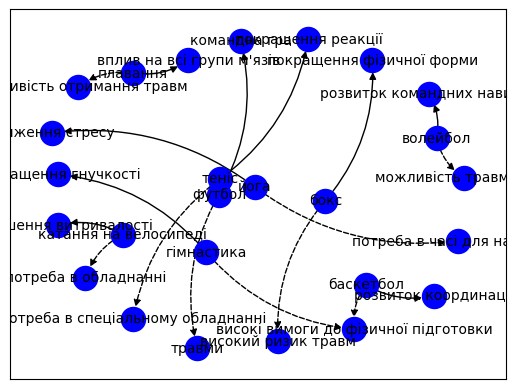

In [32]:
# списки дуг "перевага" та "недолік"
edges_p=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="перевага"]
edges_n=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="недолік"]
pos = networkx.spring_layout(G) # вибрати алгоритм візуалізації графа
# нарисувати вузли, мітки і дуги
networkx.draw_networkx_nodes(G, pos, node_color='blue')
networkx.draw_networkx_labels(G, pos, font_size=10)
networkx.draw_networkx_edges(G, pos, edgelist=edges_p, connectionstyle='arc3, rad=0.2')
networkx.draw_networkx_edges(G, pos, edgelist=edges_n, style='dashed', connectionstyle='arc3, rad=0.2')
# зберегти граф у форматі SVG
plt.savefig("graph.svg", format="svg")

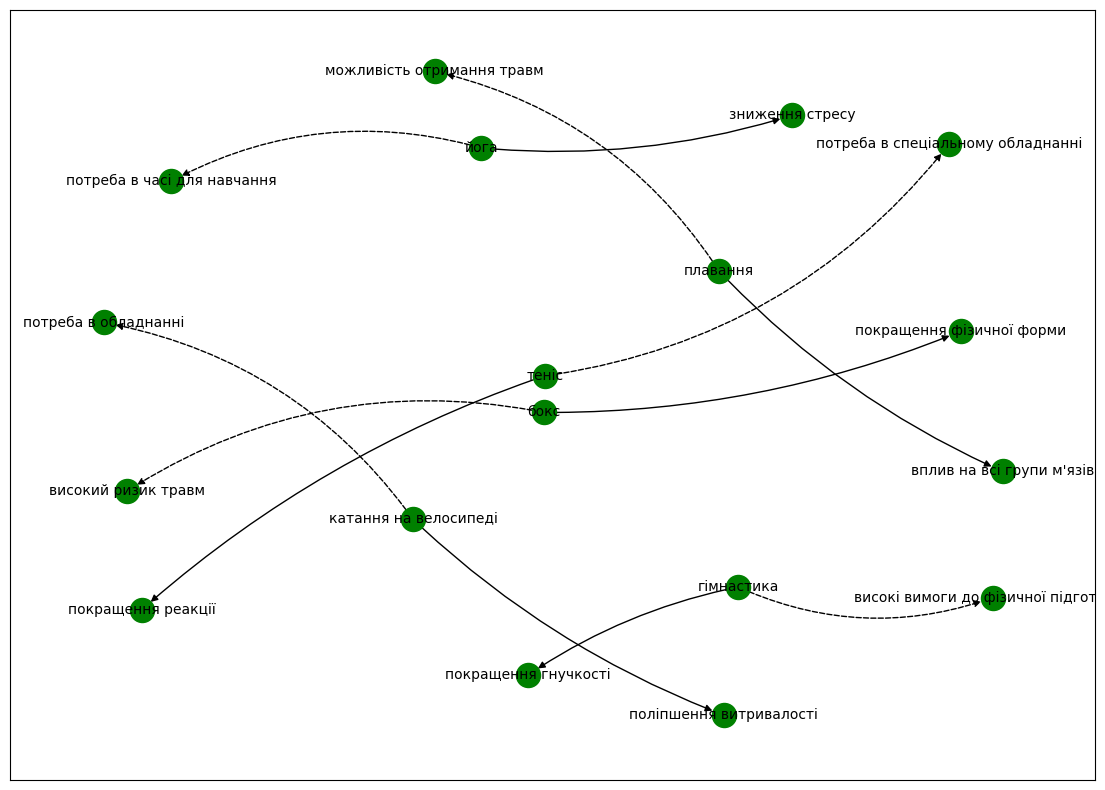

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
#Виведення з графу усіх s які містять бол
# Читаємо дані з CSV файлу
df = pd.read_csv('kb.csv')

# Відфільтровуємо рядки, де в колонці 's' немає слова 'бол'
df_filtered = df[~df['s'].str.contains('бол')]

# Створюємо граф
G = nx.DiGraph()

# Додаємо відфільтровані ребра до графа
for _, row in df_filtered.iterrows():
    G.add_edge(row['s'], row['o'], label=row['p'])

# Вибірка ребер з міткою "перевага" і "недолік"
edges_p = [(u, v) for u, v, e in G.edges(data=True) if e['label'] == "перевага"]
edges_n = [(u, v) for u, v, e in G.edges(data=True) if e['label'] == "недолік"]

# Вибір алгоритму візуалізації графа
pos = nx.spring_layout(G)

# Малюємо вузли, мітки і дуги
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color='green')
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=edges_p, connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edges(G, pos, edgelist=edges_n, style='dashed', connectionstyle='arc3, rad=0.2')

# Зберігаємо граф у форматі SVG
plt.savefig("graph1.svg", format="svg")


In [34]:
# імпорт правил і машини логічного виведення з модуля example3
from example3 import *

In [35]:
# наповнити множину F усіма фактами
F=set()
for row in df.itertuples():
    F.add((row.s, row.p, row.o))
# вивести нові факти за правилами rule1, rule2
A=reasoner(F, [rule1, rule2], ["перевага"], ["недолік"])
print(A) # усі факти
print(A-F) # нові факти

{('катання на велосипеді', 'недолік', 'потреба в обладнанні'), ('футбол', 'недолік', 'травми'), ('теніс', 'недолік', 'потреба в спеціальному обладнанні'), ('бокс', 'недолік', 'високий ризик травм'), ('потреба в обладнанні', 'недолік', 'катання на велосипеді'), ('високий ризик травм', 'недолік', 'бокс'), ('волейбол', 'недолік', 'можливість травм колін'), ('катання на велосипеді', 'перевага', 'поліпшення витривалості'), ('потреба в спеціальному обладнанні', 'недолік', 'теніс'), ('футбол', 'перевага', 'командна гра'), ('теніс', 'перевага', 'покращення реакції'), ('потреба в часі для навчання', 'недолік', 'йога'), ('плавання', 'недолік', 'можливість отримання травм'), ('травми', 'недолік', 'футбол'), ('високі вимоги до фізичної підготовки', 'недолік', 'гімнастика'), ('бокс', 'перевага', 'покращення фізичної форми'), ('баскетбол', 'недолік', 'високі вимоги до фізичної підготовки'), ('йога', 'недолік', 'потреба в часі для навчання'), ('волейбол', 'перевага', 'розвиток командних навичок'), ('

In [36]:
df

,s,p,o
0,футбол,недолік,травми
1,катання на велосипеді,недолік,потреба в обладнанні
2,теніс,недолік,потреба в спеціальному обладнанні
3,бокс,недолік,високий ризик травм
4,катання на велосипеді,перевага,поліпшення витривалості
5,волейбол,недолік,можливість травм колін
6,теніс,перевага,покращення реакції
7,плавання,недолік,можливість отримання травм
8,бокс,перевага,покращення фізичної форми
9,баскетбол,недолік,високі вимоги до фізичної підготовки


In [37]:
df.to_csv('kb.csv', index=False) # зберегти у файл